In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from nutshell import ModelData, Learner, Representation

In [2]:
# Fathom concepts

# FactSet is a dataset with three columns: subject, fact_name, fact_value
#  
# You can generate a FactSet from a data with rows and columns using 
#  load_subject_rows: source dataframe has one row per subject - with columns containing fact values
#  load_fact_rows: source dataframe has many rows per subject - one row per fact name/value pair
#  results in internal fact_data dataset with one row per subject/fact



In [110]:
class FactSet:
    
    def __init__(self, factset_name):

        self.factset_name = factset_name  # this value informs the names of model files generated
        self.fact_data = pd.DataFrame()   # internal dataset with one row per subject/fact
        self.label_data = pd.DataFrame()  # internal dataset with one row per subject
        self.subject_column = ''          # name of subject id column in input dataset
        self.label_column = ''            # name label column - this will be not be used in training
        self.fact_name_column = ''        # name of fact name column in input dataset
        self.fact_value_column = ''       # name of fact value column in input dataset
        self.fact_colnames = []           # optional: list of fact columns; default is all non subject/label columns
        self.model = None
               
    def load_subject_rows(self, df):
        
        # dataset is in the format one row per subject, one fact per column
        print('Transposing data into fact rows...')
        
        #to do
        
    
    def load_fact_rows(self, df):
               
        # dataset is in the format one row per subject/fact, each row has a fact name and value column
        self.fact_data = pd.DataFrame()
        self.fact_data['subject'] = df[self.subject_column]
        self.fact_data['fact_name'] = df[self.fact_name_column]
        self.fact_data['fact_value'] = df[self.fact_value_column]
        
        print(len(df), 'fact rows loaded')
             

In [310]:
class Fathom:
    
    def __init__(self, factset):
        
        self.factset = factset
        self.model = None
        self.subject_representation = None
        self.subject_data = pd.DataFrame() # data for output for each subject
        self.fact_representation = None    
        self.fact_data = pd.DataFrame() # data for output for each fact
             
       
    def load_model(self, model=None, modeldata=None, model_name=''):
        
        # load trained model and settings
 
        if model!=None:
            self.model = model
            md = modeldata
        else:
            if model_name=='':
                model_name = self.factset.factset_name
                
            self.model = load_model(model_name + '_model.h5')
            md = ModelData(self.factset_to_df, model_name + '_settings')

        # convert model embeddings to nutshell representation objects
        self.subject_representation = Representation(self.extract_embeddings('subject', md, include_key = True))
        self.fact_representation = Representation(self.extract_embeddings('fact', md, include_key = True))  
        
        # initialize output datasets
        self.subject_data = pd.DataFrame()
        self.subject_data['subject'] = self.subject_representation.keys
        self.fact_data = pd.DataFrame()
        self.fact_data['fact'] = self.fact_representation.keys
            
    
    def extract_embeddings(self, column_name, modeldata, include_key = False):
        
        embedding_list = self.model.get_layer('embed_' + column_name).get_weights()[0]
        
        if include_key:
            key_list = []
            for i in range(0, len(embedding_list)):
                v = modeldata.index_value[column_name][i]
                key_list.append(v)
            embedding_list = [embedding_list, key_list]
            return embedding_list
        else:
            return [embedding_list]
                   
            
    def factset_to_df(self):
        
        fact_data = self.factset.fact_data
        
        dfLearn = pd.DataFrame()        
        dfLearn['subject'] = fact_data['subject']
        dfLearn['fact'] = fact_data['fact_name'].astype('str') + '/' + fact_data['fact_value'].astype('str')
        dfLearn['is_true'] = 1
        
        return dfLearn
 
    
    def learn(self, batch_size=1024, super_epochs=1, epochs=1):
     
        # training a neural net to tell which facts are true and which are false about each subject
        #  so for every true fact about a subject, there should be an equal number of false facts
        #  false facts are taken from other subjects, so they are plausible facts       
        
        print('Preparing data for model training...')
    
        dfLearn = factset_to_df() # convert fact_data to training data format
        
        data = ModelData(dfLearn)
        data.category_columns = ['subject','fact']
        data.label_column = 'is_true'
        data.prepare_data()
        data.add_false_rows(['subject']) # TODO: need to iterate to get rid of true facts labeled as false
        #data.prepare_data() # this wipes out false rows
        data.max_validation = 1 # overfitting is the point here - no need for validation set
        data.split_data(shuffle=True)       
        
        print('Building neural network...')
        
        model = Learner(data)
        model.dropout = .01 # overfitting is the point here - minimize dropout
        model.batch_size = batch_size
        model.build_model()
        
        print('Training neural network...')

        model.train_model(self.factset.factset_name, epochs=epochs, super_epochs=super_epochs, early_stopping='loss')
        # early_stopping='loss' is because we are trying to overfit - ignoring validation loss
        
        print ('Stored model to: ', self.factset.factset_name + '_', 'files')
        load_model(model, data) # set internal model and extract embeddings
        
        
    def generate_xy(self, generate_for='subject'):
        
        # this will reduce embedding dimensions down to 2 x,y dimensions
        #  and add the x,y values to the output data set
        
        if generate_for == 'subject':
            g_representation = self.subject_representation
            g_data = self.subject_data
        else:
            generate_for = 'fact'
            g_representation= self.fact_representation
            g_data = self.fact_data
            
        print('Calculating x,y coordinates for ' + generate_for + 's (this could take a while)...')
        rep_2d = self.subject_representation.reduce_dimensions(2)
        g_data[generate_for + '_x'] = rep_2d[:,0]
        g_data[generate_for + '_y'] = rep_2d[:,1]
        print('Added ' + generate_for + '_x and ' + generate_for + '_y columns to ' + generate_for + '_data')
        
    def generate_clusters(self, cluster_count=5, generate_for='subject'):
        
        # this will create n clusters based on subject/fact embedding values
        #  and add the cluster_n value to the output data set
        # you can run this multiple times with different n values
        #  so multiple cluster sets can be added to the output to create super/sub clusters
        
        if generate_for == 'subject':
            g_representation = self.subject_representation
            g_data = self.subject_data
        else:
            generate_for = 'fact'
            g_representation= self.fact_representation
            g_data = self.fact_data
            
        print('Calculating ' + str(cluster_count) + ' subject clusters...')
        self.subject_representation.calculate_clusters(cluster_count)
        self.subject_data['cluster_' + str(cluster_count)] = self.subject_representation.clusters
        print('Added cluster_' + str(cluster_count) + ' to subject_data')
        
    def rename_cluster(self, generate_for='subject', cluster_count=5, old_cluster_name='', new_cluster_name=''):
        
        if old_cluster_name == '':
            raise Exception('You must provide a value for old_cluster_name parameter')
        if new_cluster_name=='':
            raise Exception('You must provide a string for new_cluster_name parameter')
            
        # TO DO find column, replace new value where old value is present
                    
    
    def describe_cluster(self, cluster_count, cluster_name):
        
        # return a dataframe containing all unique facts for the subset of subjects 
        #  where the subset is equal to members of a cluster
        
        # join all facts from factset.fact_data and join to subject_data
        #  to apply subject cluster names to each fact
        
        print('Applying subject clusters to all facts in factset...')
        dfClusterFacts = pd.merge(self.factset.fact_data, \
                                  self.subject_data[['subject', 'cluster_'+str(cluster_count)]],\
                                 on='subject')
        
        print('Aggregating fact metrics for subjects in/out of cluster...')
        dfDescribe = self.describe_subset(df=dfClusterFacts, col_name='cluster_'+str(cluster_count), col_value=cluster_name)
        
        return dfDescribe
        
    def describe_subset(self, df, col_name, col_value):
        
        # return a dataframe containing metrics about all unique facts in factset
        #  for each fact, provide: in_subject_count, out_subject_count, in_fact_count, out_fact_count
        
        df['in_out'] = df[col_name].apply(lambda x: 'in' if str(x)==str(col_value) else 'out')
        dfFactInOut = df.groupby(['in_out', 'fact_name', 'fact_value']).subject.nunique().reset_index()
        dfFactInOut = dfFactInOut.rename(columns={"subject": "fact_subjects"})
        dfInOut = df.groupby(['in_out']).subject.nunique().reset_index()
        dfInOut = dfInOut.rename(columns={"subject": "set_subjects"})
        total_subjects = df.subject.nunique()
        dfFactMetrics = pd.merge(dfFactInOut, dfInOut, on='in_out').reset_index()
        dfFactMetrics['fact_perc'] = dfFactMetrics.apply(lambda x: x['fact_subjects'] / x['set_subjects'], axis=1)
        dfFactsIn = dfFactMetrics[dfFactMetrics['in_out']=='in'][['fact_name', 'fact_value', 'fact_subjects', 'set_subjects', 'fact_perc']]
        dfFactsIn = dfFactsIn.rename(columns={'fact_subjects':'in_fact_subjects', 'set_subjects':'in_subjects', 'fact_perc': 'in_fact_perc'})
        dfFactsOut = dfFactMetrics[dfFactMetrics['in_out']=='out'][['fact_name', 'fact_value', 'fact_subjects', 'set_subjects', 'fact_perc']]
        dfFactsOut = dfFactsOut.rename(columns={'fact_subjects':'out_fact_subjects', 'set_subjects':'out_subjects', 'fact_perc': 'out_fact_perc'})
        dfFactMetrics = pd.merge(dfFactsIn, dfFactsOut, on=['fact_name', 'fact_value'])

        dfFactMetrics['perc_diff'] = dfFactMetrics.apply(lambda x: (x['in_fact_perc'] - x['out_fact_perc'])/x['out_fact_perc'], axis=1)
        dfFactMetrics['total_subjects'] = total_subjects
        dfFactMetrics['in_subject_perc'] = dfFactMetrics.apply(lambda x: x['in_subjects'] / x['total_subjects'], axis=1)        
        
        return dfFactMetrics
    
    
    def plot_clusters(self, cluster_count, generate_for='subject', max_points=500):
        
        # plot a small graph showing a sample of subjects/facts with dots colored by cluster
        
        if generate_for == 'subject':
            g_data = self.subject_data
        else:
            generate_for = 'fact'
            g_data = self.fact_data
            
        cl = g_data[0:max_points]['cluster_' + str(cluster_count)]
        plt.scatter(g_data[0:max_points]['subject_x'], g_data[0:max_points]['subject_y'], c=cl)

        plt.xlabel('reduced dimension x')
        plt.ylabel('reduced dimension y')

        #fig, ax = plt.subplots()
        #ax.legend()

        plt.show()        
        
               

In [276]:
df = pd.merge(fathom.factset.fact_data, \
                          fathom.subject_data[['subject', 'cluster_'+str(5)]],\
                         on='subject')




In [304]:
#df = dfxy.copy()
col_name = 'cluster_5'
col_value='4'
df['in_out'] = df[col_name].apply(lambda x: 'in' if str(x)==str(col_value) else 'out')
dfFactInOut = df.groupby(['in_out', 'fact_name', 'fact_value']).subject.nunique().reset_index()
dfFactInOut = dfFactInOut.rename(columns={"subject": "fact_subjects"})
dfInOut = df.groupby(['in_out']).subject.nunique().reset_index()
dfInOut = dfInOut.rename(columns={"subject": "set_subjects"})
total_subjects = df.subject.nunique()
dfFactMetrics = pd.merge(dfFactInOut, dfInOut, on='in_out').reset_index()
dfFactMetrics['fact_perc'] = dfFactMetrics.apply(lambda x: x['fact_subjects'] / x['set_subjects'], axis=1)
dfFactsIn = dfFactMetrics[dfFactMetrics['in_out']=='in'][['fact_name', 'fact_value', 'fact_subjects', 'set_subjects', 'fact_perc']]
dfFactsIn = dfFactsIn.rename(columns={'fact_subjects':'in_fact_subjects', 'set_subjects':'in_subjects', 'fact_perc': 'in_fact_perc'})
dfFactsOut = dfFactMetrics[dfFactMetrics['in_out']=='out'][['fact_name', 'fact_value', 'fact_subjects', 'set_subjects', 'fact_perc']]
dfFactsOut = dfFactsOut.rename(columns={'fact_subjects':'out_fact_subjects', 'set_subjects':'out_subjects', 'fact_perc': 'out_fact_perc'})
dfFactMetrics = pd.merge(dfFactsIn, dfFactsOut, on=['fact_name', 'fact_value'])

dfFactMetrics['perc_diff'] = dfFactMetrics.apply(lambda x: (x['in_fact_perc'] - x['out_fact_perc'])/x['out_fact_perc'], axis=1)
dfFactMetrics['total_subjects'] = total_subjects
dfFactMetrics['in_subject_perc'] = dfFactMetrics.apply(lambda x: x['in_subjects'] / x['total_subjects'], axis=1)


print(dfFactMetrics[0:10])



  fact_name  fact_value  in_fact_subjects  in_subjects  in_fact_perc  \
0   product           2                 3         2038      0.001472   
1   product           3                 2         2038      0.000981   
2   product          10                36         2038      0.017664   
3   product          23                 7         2038      0.003435   
4   product          25                15         2038      0.007360   
5   product          31                 1         2038      0.000491   
6   product          32                 3         2038      0.001472   
7   product          34                35         2038      0.017174   
8   product          35                 4         2038      0.001963   
9   product          43                 2         2038      0.000981   

   out_fact_subjects  out_subjects  out_fact_perc  perc_diff  total_subjects  \
0                  5          7962       0.000628   1.344063           10000   
1                  5          7962       0.0006

In [296]:
#dfFactMetrics[0:5]
dfFactsIn = dfFactMetrics[dfFactMetrics['in_out']=='in']

#[['fact_name', 'fact_value', 'fact_subjects', 'set_subjects', 'fact_perc']]


In [311]:
fathom = Fathom(facts)
#fathom.learn(super_epochs=3, epochs=15, batch_size=8192)
fathom.load_model(model_name='grocery')

In [312]:
fathom.generate_clusters()
#fathom.generate_xy()

Calculating 5 subject clusters...
Added cluster_5 to subject_data


In [313]:
dfDescribe = fathom.describe_cluster(5,0)

Applying subject clusters to all facts in factset...
Aggregating fact metrics for subjects in/out of cluster...


In [314]:
dfDescribe[0:10]

,fact_name,fact_value,in_fact_subjects,in_subjects,in_fact_perc,out_fact_subjects,out_subjects,out_fact_perc,perc_diff,total_subjects,in_subject_perc
0,product,2,4,1636,0.002445,4,8364,0.000478,4.112469,10000,0.1636
1,product,3,3,1636,0.001834,4,8364,0.000478,2.834352,10000,0.1636
2,product,10,17,1636,0.010391,63,8364,0.007532,0.379555,10000,0.1636
3,product,23,5,1636,0.003056,22,8364,0.002630,0.161925,10000,0.1636
4,product,25,4,1636,0.002445,26,8364,0.003109,-0.213466,10000,0.1636
5,product,32,1,1636,0.000611,5,8364,0.000598,0.022494,10000,0.1636
6,product,34,20,1636,0.012225,83,8364,0.009923,0.231920,10000,0.1636
7,product,35,4,1636,0.002445,6,8364,0.000717,2.408313,10000,0.1636
8,product,43,3,1636,0.001834,5,8364,0.000598,2.067482,10000,0.1636
9,product,44,2,1636,0.001222,4,8364,0.000478,1.556235,10000,0.1636


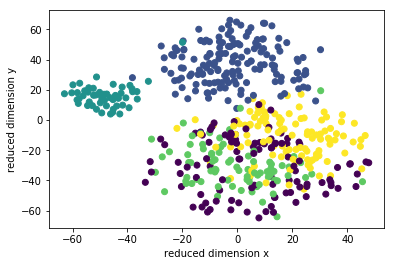

  subject  cluster_5  subject_x  subject_y cluster_6
0   <pad>          3  -5.148042 -16.010481         3
1   <unk>          4   4.587092  -3.472505         4
2  131080          2 -48.370846  13.105368         2
3      11          4   3.460814 -10.007190         4
4  131087          1 -10.186548  24.243450         1
5  163858          4  17.728691 -20.966137         4
6  163860          4   9.893294   1.799760         4
7  196631          1  15.466464  45.583527         1
8      26          4   4.563170   5.711637         4
9      28          3  14.420915 -64.114136         3


In [273]:

fathom.plot_clusters(cluster_count=6)
print(fathom.subject_data[0:10])

In [268]:
dfxy = fathom.subject_data.copy()

In [175]:
# as a sample, use instacart purchases
# we will use users as subjects and products purchased as facts

dataPath = '/Users/Miles/Documents/Datasets/Instacart/'
dfProducts = pd.read_csv(dataPath + 'products.csv')
dfOrders = pd.read_csv(dataPath + 'orders.csv')
dfOrderProducts = pd.read_csv(dataPath + 'order_products__prior.csv')

In [176]:
# full set has 206K unique users
dfOrders['user_id'].nunique()

# take a random sample of 10K users - that is more managable
# also appears it takes more epochs to train the model, the more users there are :(
dfSample = pd.DataFrame()
dfSample['user_id'] = dfOrders['user_id'].unique()
dfSample = dfSample.sample(n=10000)

dfOrders = pd.merge(dfSample, dfOrders, on='user_id').reset_index()

In [177]:
# create list of user ids and products they have ordered

dfUserProducts = pd.merge(dfOrders, dfOrderProducts, on='order_id')[['user_id', 'product_id']].\
    sort_values(['user_id', 'product_id']).groupby(['user_id', 'product_id']).count().reset_index()

In [178]:
dfUserProducts['fact_name'] = 'product'

In [211]:
facts = FactSet('grocery')
facts.subject_column = 'user_id'
facts.fact_name_column = 'fact_name'
facts.fact_value_column = 'product_id'
facts.load_fact_rows(dfUserProducts)

649464 fact rows loaded


In [231]:
fathom = Fathom(facts)
#fathom.learn(super_epochs=3, epochs=15, batch_size=8192)
fathom.load_model(model_name='grocery')

NameError: name 'factset_to_df' is not defined

In [185]:
subject_embeddings = fathom.model.extract_embedding('subject', include_key=True)
fact_embeddings = fathom.model.extract_embedding('fact', include_key=True)

In [187]:
subject_representation = Representation(subject_embeddings)

In [193]:
subject_representation.calculate_clusters(5)

In [195]:
print(subject_representation.clusters[0:20])

[3 4 2 4 1 4 4 1 4 3 1 4 1 1 1 0 1 4 4 0]


In [188]:
subject_2d = subject_representation.reduce_dimensions(2)

In [189]:
print(subject_2d[0:5])

[[ -5.1480422  -16.01048088]
 [  4.58709192  -3.47250485]
 [-48.37084579  13.10536766]
 [  3.46081352 -10.00718975]
 [-10.18654823  24.24345016]]


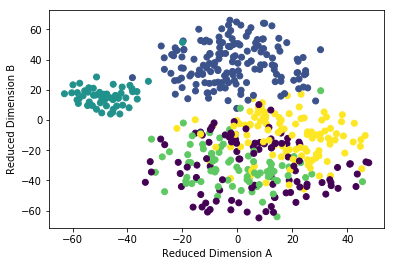

In [252]:
import matplotlib.pyplot as plt

max_points = 500
#plt.scatter(subject_2d[:max_points,0], subject_2d[:max_points,1], color='b')
cl = subject_representation.clusters[0:max_points]
plt.scatter(subject_2d[:max_points,0], subject_2d[:max_points,1], c=cl, label='hi')

plt.xlabel('Reduced Dimension A')
plt.ylabel('Reduced Dimension B')

#fig, ax = plt.subplots()
#ax.legend()

plt.show()